In [348]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [349]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

# Data Import and Consolidation

Note about data: I found the first dataset (df) from a [Kaggle competition](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) which referenced IBM Sample Set as the source of the data. I found the data on the [Cognos Analytics site](https://community.ibm.com/accelerators/?context=analytics&query=churn&type=Data) associated with IBM, along with additional data for the same company that includes customer location and reason for churn. The following code rearranges all new information into one dataset.

In [350]:
# Kaggle data - will refer to as dataset 0
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo Bootcamp/Project 2/WA_Fn-UseC_-Telco-Customer-Churn[1].csv')
# First dataset from Cognos analytics (will confirm it's the same data as above)
df1 = pd.read_excel('/content/drive/MyDrive/Coding Dojo Bootcamp/Project 2/Data/CustomerChurn.xlsx')
# Second data set from Cognos analytics
df2 = pd.read_excel('/content/drive/MyDrive/Coding Dojo Bootcamp/Project 2/Data/Telco_customer_churn.xlsx')
# Third data set from Cognos analytics
df3 = pd.read_excel('/content/drive/MyDrive/Coding Dojo Bootcamp/Project 2/Data/Telco_customer_churn_status.xlsx')

Combining dataset 0 and 1

In [351]:
set(df.columns.str.lower()).difference(df1.columns.str.lower().str.replace(' ', ''))
# gender column is unique to kaggle dataset

{'gender'}

In [352]:
set(df1.columns.str.lower().str.replace(' ', '')).difference(df.columns.str.lower())
#loyalty id is unique to cognos dataset

{'loyaltyid'}

In [353]:
df = df.sort_values(by = 'customerID').reset_index(drop = True)
df1 = df1.sort_values(by = 'Customer ID').reset_index(drop = True)
(df['customerID'] != df1['Customer ID']).sum()
# all the same customer IDs in the same order in both datasets

0

> The only difference between Kaggle's data and the data from Cognos is that Kaggle's data has a gender feature, and Cognos's data has a loyality ID feature. Will keep the Kaggle dataset and add the loyalty ID feature to it:

In [354]:
df['LoyaltyID'] = df1['LoyaltyID']

Combining new rolling dataset (combo of dataset 0 and 1) and dataset 2

In [355]:
df2.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Active Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [356]:
df2.drop(columns = 'Count', inplace = True) # just a column of 1s
df2.drop(columns = 'Churn Label', inplace = True) #duplicated information from Churn Value (yes or no vs 1 or 0)

In [357]:
# new columns from dataset2
set(df2.columns.str.lower().str.replace(' ', '')).difference(df.columns.str.lower())

{'activescore',
 'churnreason',
 'churnvalue',
 'city',
 'cltv',
 'country',
 'latitude',
 'latlong',
 'longitude',
 'state',
 'tenuremonths',
 'zipcode'}

In [358]:
df = df.sort_values(by = 'customerID').reset_index(drop = True)
df2 = df2.sort_values(by = 'CustomerID').reset_index(drop = True)
(df['customerID'] != df2['CustomerID']).sum()
# all the same customer IDs in the same order in both datasets

0

In [359]:
newdata = df2[['CustomerID', 'Churn Reason', 'Active Score', 'City', 'CLTV', 'Country', 'Latitude', 'Longitude', 'State', 'Zip Code']] 

In [360]:
df = pd.merge(left=df, right=newdata, left_on='customerID', right_on='CustomerID')

In [361]:
df['Active Score'] = df['Active Score'].apply(lambda x: 100 - x)
# the original feature was called "Churn Score," a measure of how likely someone was to churn based on their use of services. 
# The higher the churn score, the less the activity.
# I changed it to "active score" since I think this makes more sense
# but, activity and churn score are inversely related

In [362]:
df.drop(columns = 'CustomerID', inplace = True)

Combining new rolling dataset (combo of 0, 1, and 2) with dataset 3

In [363]:
df3.head()

,Customer ID,Count,Quarter,Satisfaction Score,Customer Status,Churn Label,Churn Value,Active Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,1,Q3,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,1,Q3,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,1,Q3,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,1,Q3,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,1,Q3,2,Churned,Yes,1,67,2793,Price,Extra data charges


In [364]:
df3.drop(columns = ['Quarter', 'Count'], inplace = True) # all Q3 and 1, respectively

In [365]:
df = df.sort_values(by = 'customerID').reset_index(drop = True)
df3 = df3.sort_values(by = 'Customer ID').reset_index(drop = True)
(df['customerID'] != df3['Customer ID']).sum()
# all the same customer IDs in the same order in both datasets

0

In [366]:
# new columns from dataset3
set(df3.columns.str.lower().str.replace(' ', '')).difference(df.columns.str.lower().str.replace(' ', ''))

{'churncategory',
 'churnlabel',
 'churnvalue',
 'customerstatus',
 'satisfactionscore'}

In [367]:
newdata = df3[['Customer ID', 'Churn Category', 'Customer Status', 'Satisfaction Score']] 

In [368]:
df = pd.merge(left=df, right=newdata, left_on='customerID', right_on='Customer ID')

In [369]:
df.drop(columns = 'Customer ID', inplace = True)
df
# now contains all data from all datasets! 

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,City,CLTV,Country,Latitude,Longitude,State,Zip Code,Churn Category,Customer Status,Satisfaction Score
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,DSL,No,...,Frazier Park,2205,United States,34.827662,-118.999073,California,93225,NaN,Stayed,3
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,DSL,No,...,Glendale,5414,United States,34.162515,-118.203869,California,91206,NaN,Stayed,5
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,Fiber optic,No,...,Costa Mesa,4479,United States,33.645672,-117.922613,California,92627,Competitor,Churned,1
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,Fiber optic,No,...,Martinez,3714,United States,38.014457,-122.115432,California,94553,Dissatisfaction,Churned,1
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,Fiber optic,No,...,Camarillo,3464,United States,34.227846,-119.079903,California,93010,Dissatisfaction,Churned,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,0,No,No,13,Yes,No,DSL,Yes,...,La Mesa,3161,United States,32.759327,-116.997260,California,91941,NaN,Stayed,4
7039,9992-RRAMN,Male,0,Yes,No,22,Yes,Yes,Fiber optic,No,...,Riverbank,5248,United States,37.734971,-120.954271,California,95367,Dissatisfaction,Churned,1
7040,9992-UJOEL,Male,0,No,No,2,Yes,No,DSL,No,...,Elk,5870,United States,39.108252,-123.645121,California,95432,NaN,Joined,5
7041,9993-LHIEB,Male,0,Yes,Yes,67,Yes,No,DSL,Yes,...,Solana Beach,4792,United States,33.001813,-117.263628,California,92075,NaN,Stayed,3


# Data Cleaning

## Consistent Mapping of Binary Yes / No Columns

In [370]:
# change to consistent mapping of binary yes/no columns
#df[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']] = \
#df[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']].replace({"No": 0, "Yes": 1})

df['SeniorCitizen'] = df['SeniorCitizen'].replace({0: "No", 1: "Yes"}) # for ease of graphing, will later change to 0 and 1s

In [371]:
dftemp = df.copy()
dftemp['Churn'] = dftemp['Churn'].replace({"No": 0, "Yes": 1})
# if needed

## Duplicated / Missing Values

In [372]:
df.duplicated().sum()
# no duplicated values

0

In [373]:
df.isna().sum()

customerID               0
gender                   0
SeniorCitizen            0
Partner                  0
Dependents               0
tenure                   0
PhoneService             0
MultipleLines            0
InternetService          0
OnlineSecurity           0
OnlineBackup             0
DeviceProtection         0
TechSupport              0
StreamingTV              0
StreamingMovies          0
Contract                 0
PaperlessBilling         0
PaymentMethod            0
MonthlyCharges           0
TotalCharges             0
Churn                    0
LoyaltyID                0
Churn Reason          5174
Active Score             0
City                     0
CLTV                     0
Country                  0
Latitude                 0
Longitude                0
State                    0
Zip Code                 0
Churn Category        5174
Customer Status          0
Satisfaction Score       0
dtype: int64

In [374]:
df[df['Churn Reason'].isna()]['Churn'].value_counts()

No    5174
Name: Churn, dtype: int64

In [375]:
df[df['Churn Category'].isna()]['Churn'].value_counts()

No    5174
Name: Churn, dtype: int64

The missing values in Churn Reason and Churn Category represent members who have not churned. I will fill in those missing values with the customer status from another column in the dataframe.

In [376]:
df['Churn Reason'].fillna(df['Customer Status'], inplace = True)
df['Churn Category'].fillna(df['Customer Status'], inplace = True)

In [377]:
df.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
Churn                 0
LoyaltyID             0
Churn Reason          0
Active Score          0
City                  0
CLTV                  0
Country               0
Latitude              0
Longitude             0
State                 0
Zip Code              0
Churn Category        0
Customer Status       0
Satisfaction Score    0
dtype: int64

In [378]:
df.dtypes

customerID             object
gender                 object
SeniorCitizen          object
Partner                object
Dependents             object
tenure                  int64
PhoneService           object
MultipleLines          object
InternetService        object
OnlineSecurity         object
OnlineBackup           object
DeviceProtection       object
TechSupport            object
StreamingTV            object
StreamingMovies        object
Contract               object
PaperlessBilling       object
PaymentMethod          object
MonthlyCharges        float64
TotalCharges           object
Churn                  object
LoyaltyID               int64
Churn Reason           object
Active Score            int64
City                   object
CLTV                    int64
Country                object
Latitude              float64
Longitude             float64
State                  object
Zip Code                int64
Churn Category         object
Customer Status        object
Satisfacti

The TotalCharges column should be a float64 dtype, but it is being read as an object due to some rows having a missing value filled in with the space character. These correspond to customers who have a tenure of 0, or have not yet generated their first bill. Below I have replaced each of the missing values with a 0 (as a float type).

In [379]:
df.loc[df['TotalCharges'] == ' ', ['tenure', 'Customer Status']] 

,tenure,Customer Status
945,0,Stayed
1731,0,Stayed
1906,0,Stayed
2025,0,Stayed
2176,0,Stayed
2250,0,Stayed
2855,0,Stayed
3052,0,Stayed
3118,0,Stayed
4054,0,Stayed


In [380]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0).astype('float32')

## Numerical Columns
- Checking for outliers here

In [381]:
df.describe()

,tenure,MonthlyCharges,TotalCharges,LoyaltyID,Active Score,CLTV,Latitude,Longitude,Zip Code,Satisfaction Score
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.731201,550382.651001,41.300582,4400.295755,36.282441,-119.798880,93521.964646,3.244924
std,24.559481,30.090047,2266.793457,260776.118690,21.525131,1183.057152,2.455723,2.157889,1865.794555,1.201657
min,0.000000,18.250000,0.000000,100346.000000,0.000000,2003.000000,32.555828,-124.301372,90001.000000,1.000000
25%,9.000000,35.500000,398.549988,323604.500000,25.000000,3469.000000,34.030915,-121.815412,92102.000000,3.000000
50%,29.000000,70.350000,1394.550049,548704.000000,39.000000,4527.000000,36.391777,-119.730885,93552.000000,3.000000
75%,55.000000,89.850000,3786.599976,776869.000000,60.000000,5380.500000,38.224869,-118.043237,95351.000000,4.000000
max,72.000000,118.750000,8684.799805,999912.000000,95.000000,6500.000000,41.962127,-114.192901,96161.000000,5.000000


In [382]:
# outlier detection
num_cols = df.columns[df.dtypes!='object']
cols_with_outliers = {}

for col in num_cols:
    df_nonzero = df[df[col] != 0]
    print(f"* Column= {col}, median = {df_nonzero[col].median()}")
    outliers = df_nonzero[np.abs(stats.zscore(df_nonzero[col]) > 3)]
    print(f"number of outliers:  {outliers.shape[0]}")
    if (outliers.shape[0]):
        cols_with_outliers[col] = outliers.shape[0]
    print('\n\n')

* Column= tenure, median = 29.0
number of outliers:  0



* Column= MonthlyCharges, median = 70.35
number of outliers:  0



* Column= TotalCharges, median = 1397.47509765625
number of outliers:  0



* Column= LoyaltyID, median = 548704.0
number of outliers:  0



* Column= Active Score, median = 39.0
number of outliers:  0



* Column= CLTV, median = 4527.0
number of outliers:  0



* Column= Latitude, median = 36.391777
number of outliers:  0



* Column= Longitude, median = -119.730885
number of outliers:  0



* Column= Zip Code, median = 93552.0
number of outliers:  0



* Column= Satisfaction Score, median = 3.0
number of outliers:  0





## Categorical Columns

In [383]:
# checking for inconsistencies in categorical data
data_types = df.dtypes
str_cols = data_types[data_types =='object'].index
for col in str_cols:
    print(f'- {col}:')
    print(df[col].value_counts(dropna=False))
    print("\n****************")

- customerID:
0002-ORFBO    1
6616-AALSR    1
6625-UTXEW    1
6625-IUTTT    1
6625-FLENO    1
             ..
3352-RICWQ    1
3352-ALMCK    1
3351-NQLDI    1
3351-NGXYI    1
9995-HOTOH    1
Name: customerID, Length: 7043, dtype: int64

****************
- gender:
Male      3555
Female    3488
Name: gender, dtype: int64

****************
- SeniorCitizen:
No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64

****************
- Partner:
No     3641
Yes    3402
Name: Partner, dtype: int64

****************
- Dependents:
No     4933
Yes    2110
Name: Dependents, dtype: int64

****************
- PhoneService:
Yes    6361
No      682
Name: PhoneService, dtype: int64

****************
- MultipleLines:
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

****************
- InternetService:
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

****************
- OnlineSecurity:
No             

No glaring inconsistencies, but will drop Country and State columns because they are the same for every row.

In [384]:
df.drop(columns = ['Country', 'State'], inplace = True)

# Exploratory Data Visualization

## Exploration of Target

In [385]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [386]:
percentChurn = df['Churn'].value_counts(normalize = True)
percentChurn

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

The dataset is unbalanced. This means I will probably have to use techniques to handle this during the model development process.

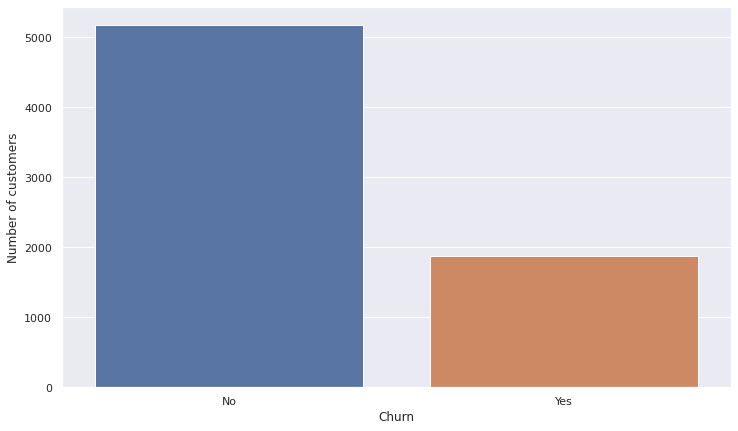

In [387]:
sns.countplot(data = df, x = 'Churn').set(ylabel = "Number of customers");

1869 (or 27%) customers have churned. How much monthly revenue is lost due to these customers leaving?

[Text(0, 0.5, '% Monthly Revenue'),
 Text(0.5, 1.0, 'Churned customers account for the loss of 31% monthly revenue.')]

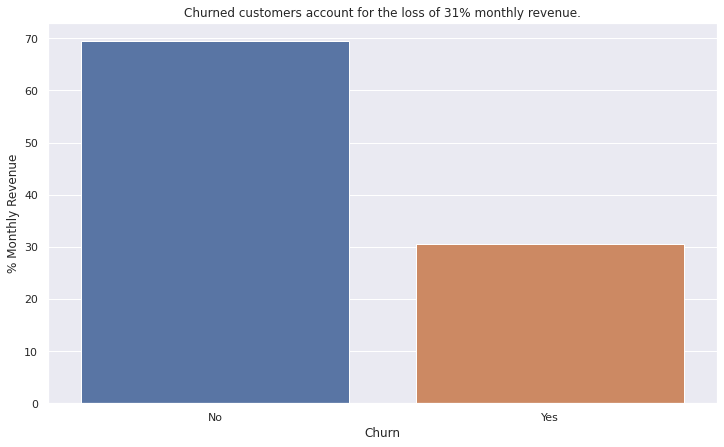

In [388]:
sumMonthChargesByGroup = df.groupby('Churn')['MonthlyCharges'].sum() #total monthly charges by group
toPlot = sumMonthChargesByGroup/sumMonthChargesByGroup.sum() * 100 # percentage of monthly charges by group

sns.set(font_scale = 1)
sns.barplot(x = toPlot.index, y = toPlot.values).set(title = 'Churned customers account for the loss of 31% monthly revenue.', ylabel = '% Monthly Revenue')

What are the most common reasons given for churn?

In [389]:
df_churn = df[df['Churn'] == "Yes"]
df_nochurn = df[df['Churn'] == "No"]

In [390]:
df_churn['Churn Reason'].value_counts()

Attitude of support person                   192
Competitor offered higher download speeds    189
Competitor offered more data                 162
Don't know                                   154
Competitor made better offer                 140
Attitude of service provider                 135
Competitor had better devices                130
Network reliability                          103
Product dissatisfaction                      102
Price too high                                98
Service dissatisfaction                       89
Lack of self-service on Website               88
Extra data charges                            57
Moved                                         53
Limited range of services                     44
Lack of affordable download/upload speed      44
Long distance charges                         44
Poor expertise of phone support               20
Poor expertise of online support              19
Deceased                                       6
Name: Churn Reason, 

Text(0, 0.5, 'Given Churn Reason')

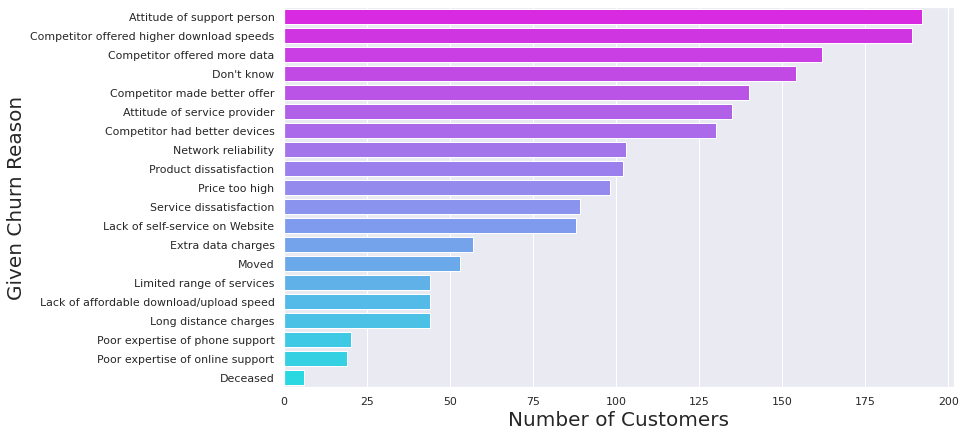

In [391]:
plt.rcParams['figure.figsize'] = (12, 7)
sns.countplot(data = df_churn, y = 'Churn Reason', order = df_churn['Churn Reason'].value_counts().index, palette = "cool_r")
plt.xlabel('Number of Customers', fontdict={'fontsize': 20})
plt.ylabel('Given Churn Reason', fontdict={'fontsize': 20})

## Univariate Feature Exploration

In [392]:
str_cols = df.columns[df.dtypes=='object']


str_cols = np.delete(str_cols, [0,17,18, 19, 20, 21]) 
# columns to drop:
# customerID - index 0
# Churn - index 17
# Churn Reason - index 18
# City - index 19
# Churn Category - index 20
# Customer Status = index 21
# Customer Status - index 
str_cols
str_cols.size

16

In [393]:
str_cols

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

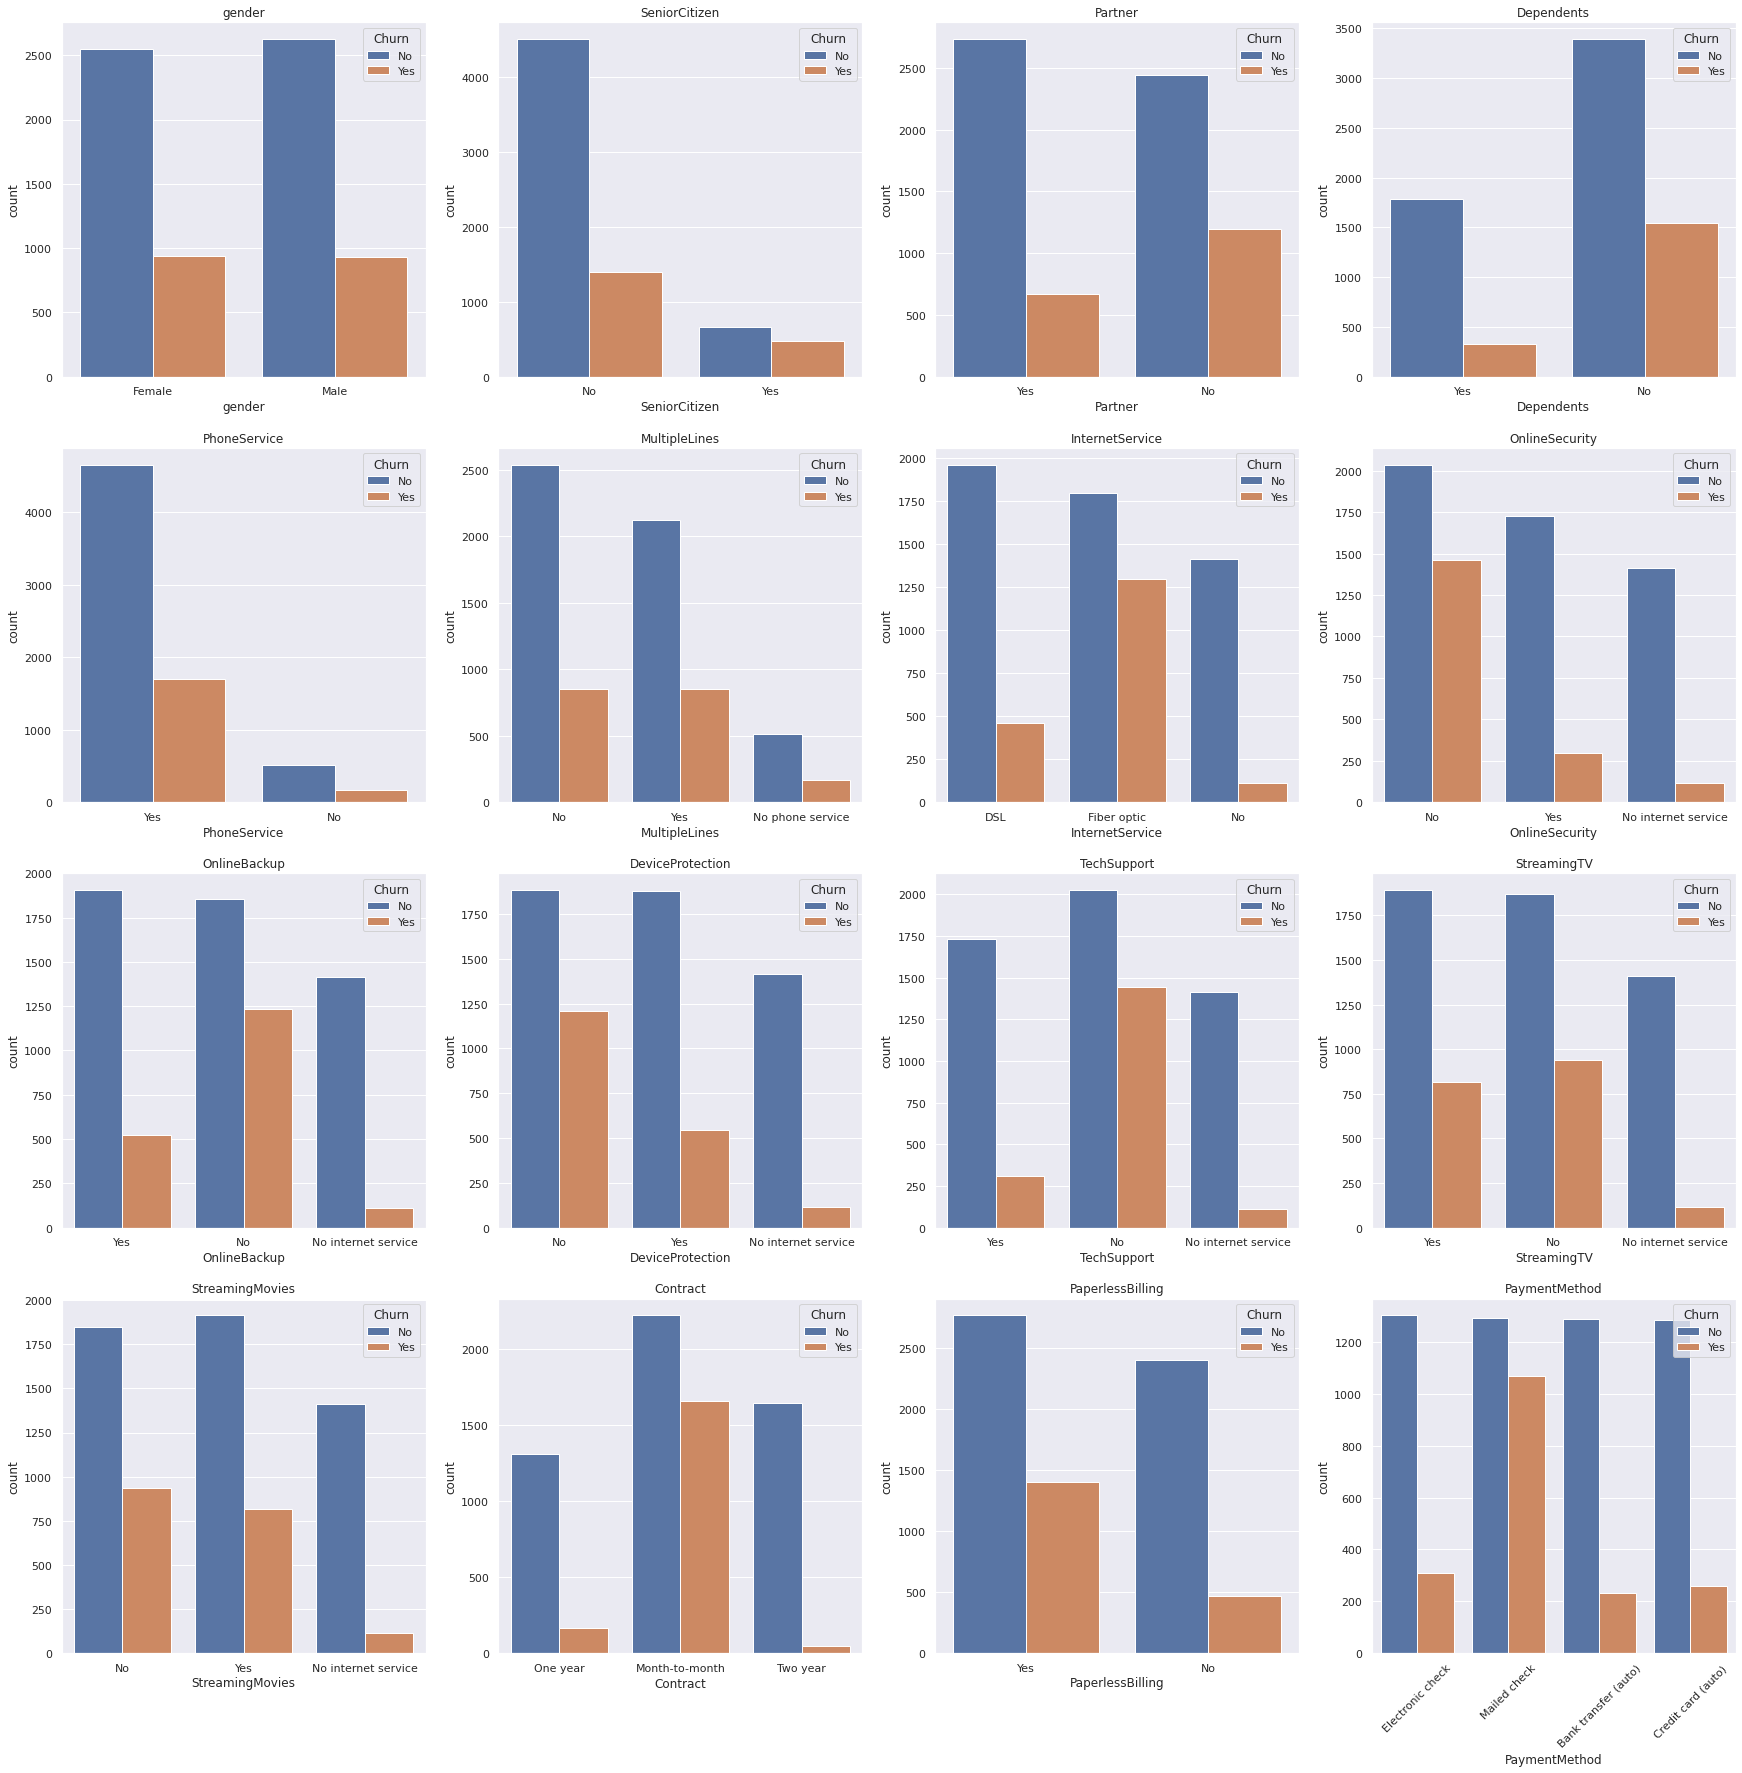

In [394]:
fig, axes = plt.subplots(4, 4, figsize=(30, 30))
axes = axes.flatten()

for i, col in zip(range(0, str_cols.size), str_cols):
    sns.countplot(data = df, x = col, ax = axes[i], hue = 'Churn')
    #axes[i].set_xticklabels(axes[i].get_xticklabels(),rotation = 45)
    axes[i].set_title(col)

# fixing readability of PaymentMethod graph
axes[15].set_xticklabels(['Electronic check', 'Mailed check', 'Bank transfer (auto)', 'Credit card (auto)'], rotation = 45);

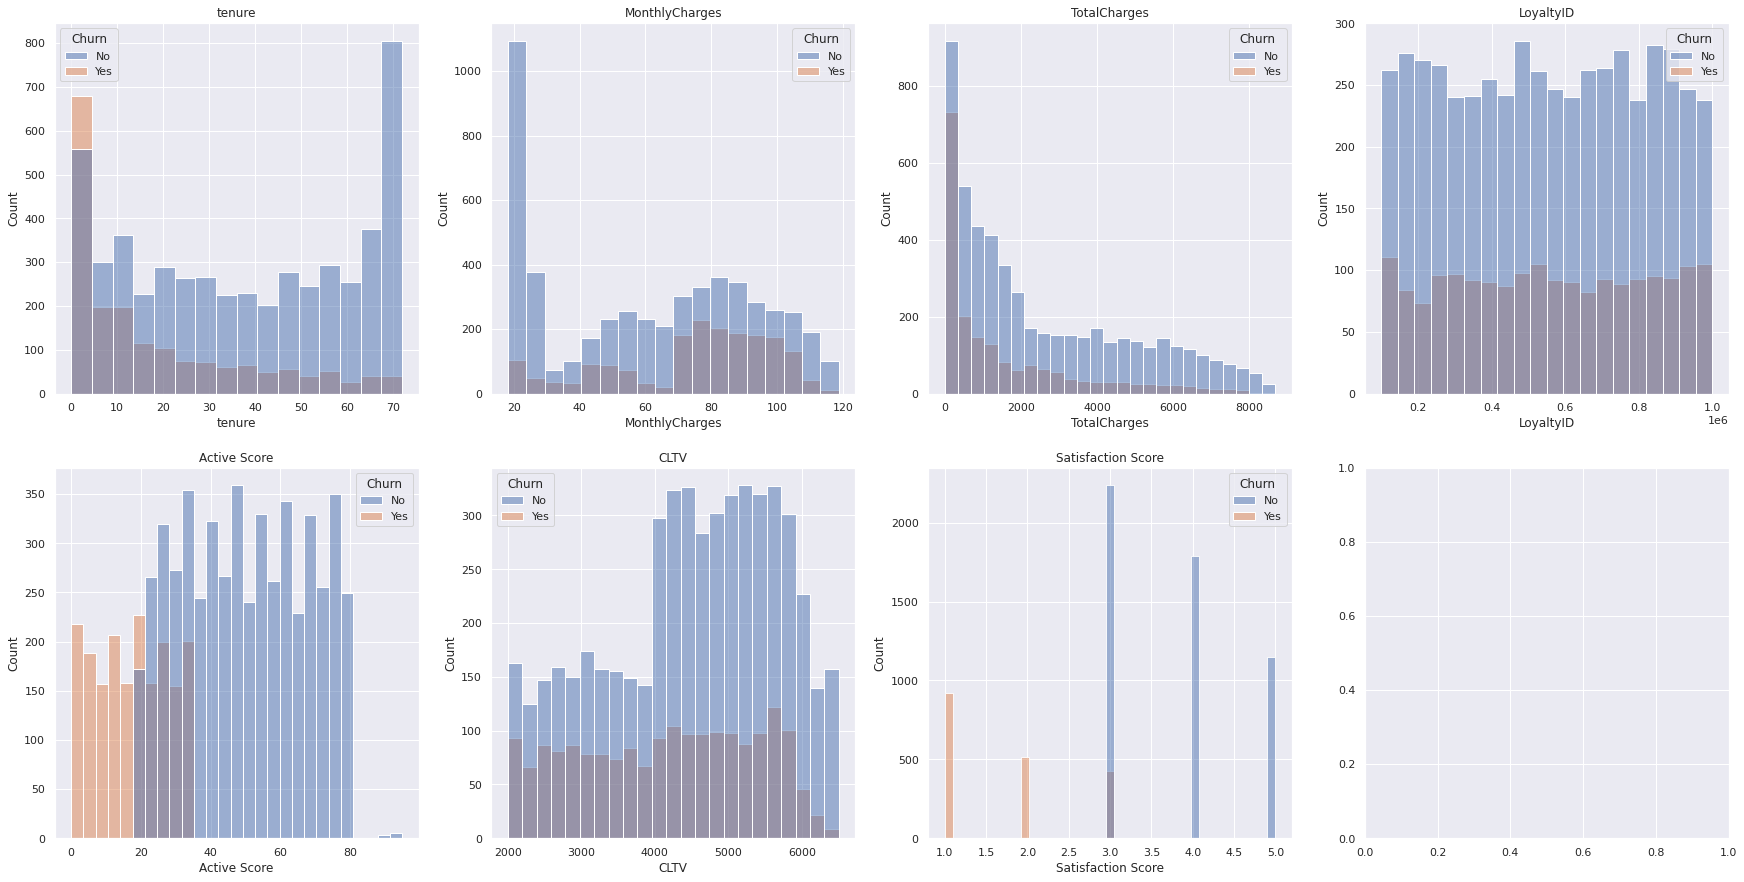

In [395]:
# histograms

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'LoyaltyID', 'Active Score',\
       'CLTV', 'Satisfaction Score']
# numeric columns NOT related to location (which will be examined later)

fig, axes = plt.subplots(2, 4, figsize=(30, 15))
axes = axes.flatten()

for i, col in zip(range(0, len(num_cols)), num_cols):
    sns.histplot(data = df, x = col, ax = axes[i], hue = 'Churn')
    axes[i].set_title(col)

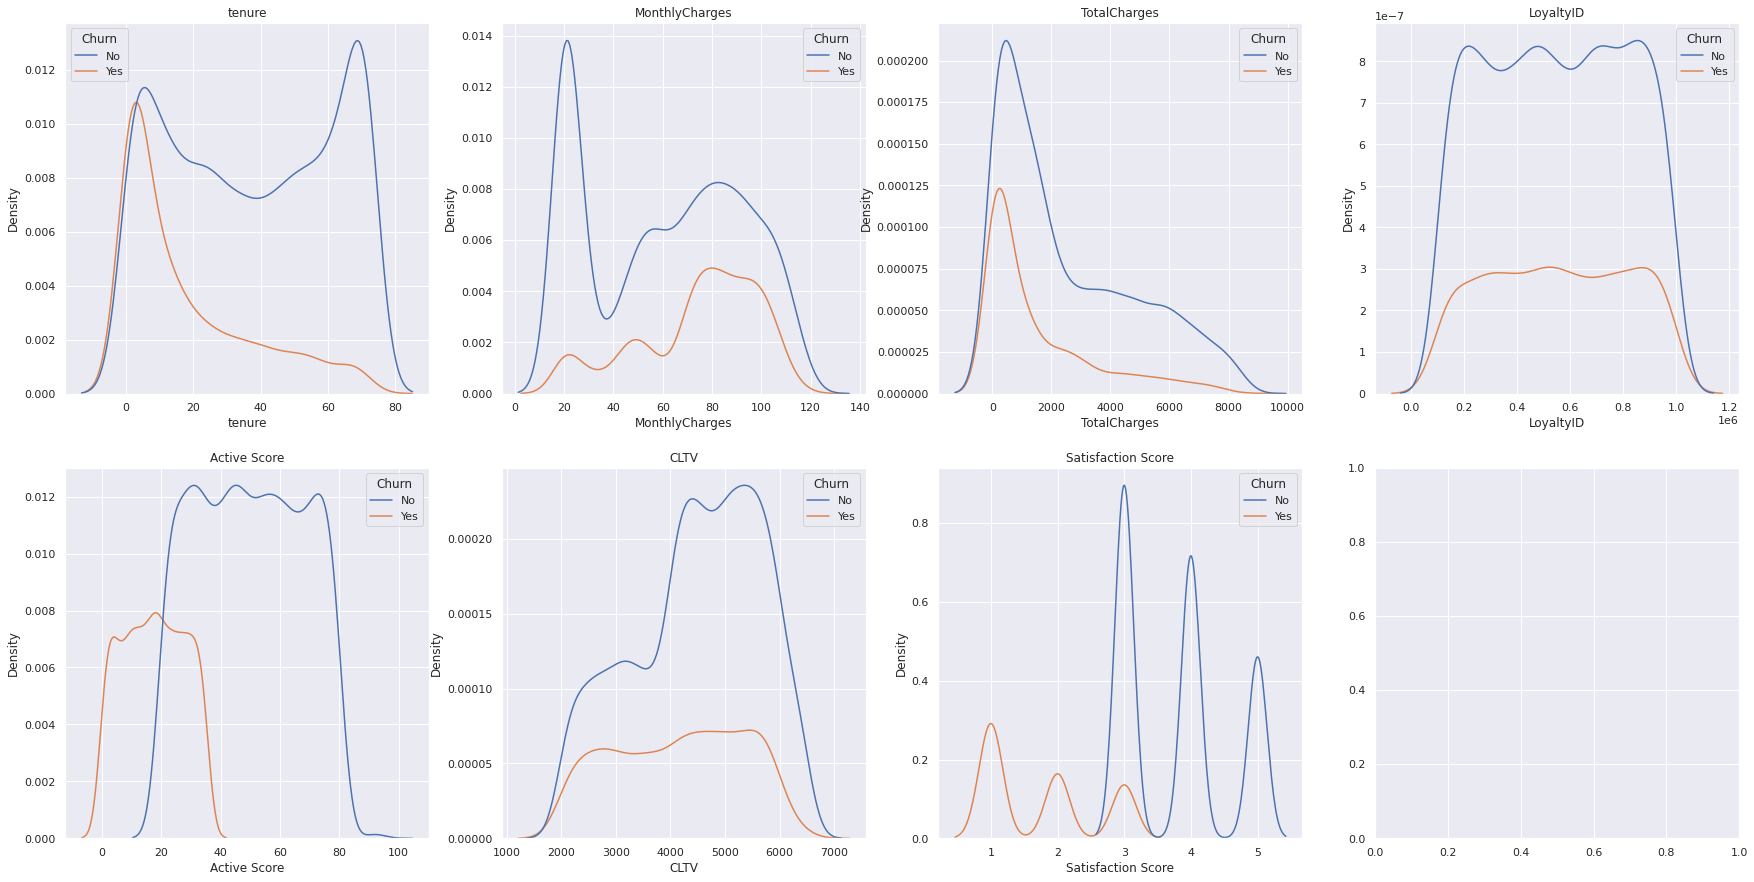

In [396]:
# density plots

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'LoyaltyID', 'Active Score',\
       'CLTV', 'Satisfaction Score']

fig, axes = plt.subplots(2, 4, figsize=(30, 15))
axes = axes.flatten()

for i, col in zip(range(0, len(num_cols)), num_cols):
    sns.kdeplot(data = df, x = col, ax = axes[i], hue = 'Churn')
    axes[i].set_title(col)

Text(0.5, 0.98, 'Distribution of Numeric Features by Churn')

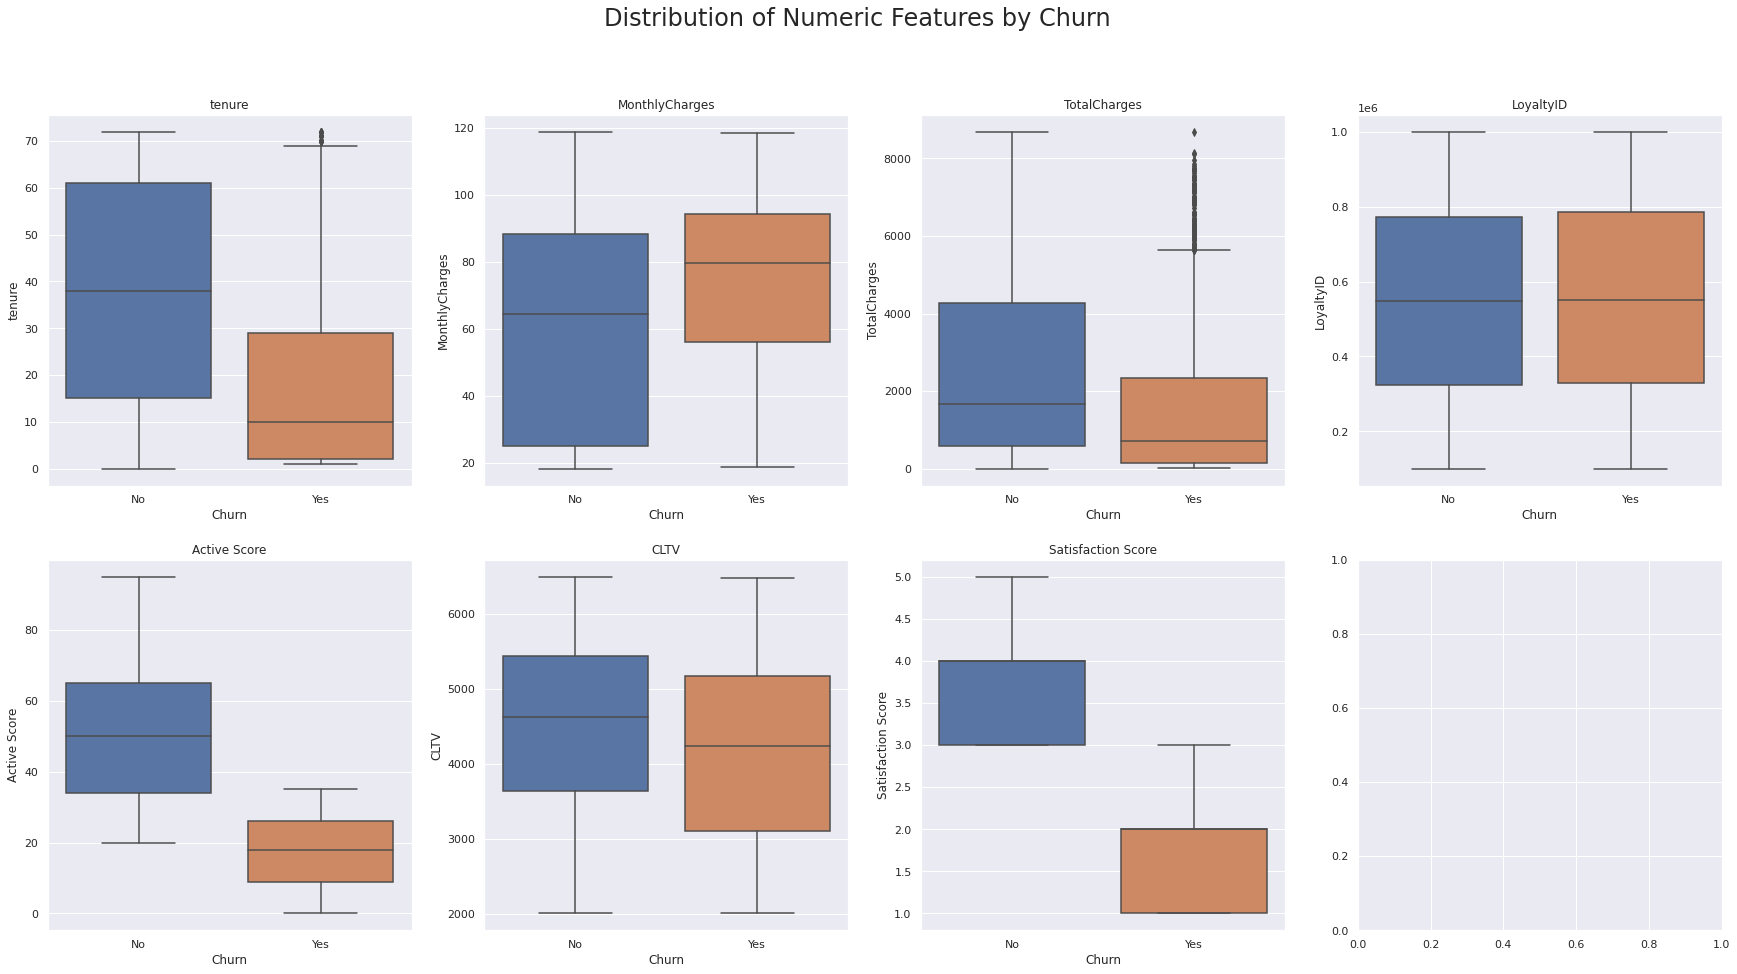

In [397]:
# box plots - churned customers

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'LoyaltyID', 'Active Score',\
       'CLTV', 'Satisfaction Score']


fig, axes = plt.subplots(2, 4, figsize=(30, 15))
axes = axes.flatten()

for i, col in zip(range(0, len(num_cols)), num_cols):
    sns.boxplot(data = df, x = "Churn", y = col, ax = axes[i])
    axes[i].set_title(col)

fig.suptitle("Distribution of Numeric Features by Churn", fontsize = 24)

In [398]:
df.columns[df.dtypes!='object']

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'LoyaltyID', 'Active Score',
       'CLTV', 'Latitude', 'Longitude', 'Zip Code', 'Satisfaction Score'],
      dtype='object')

Location

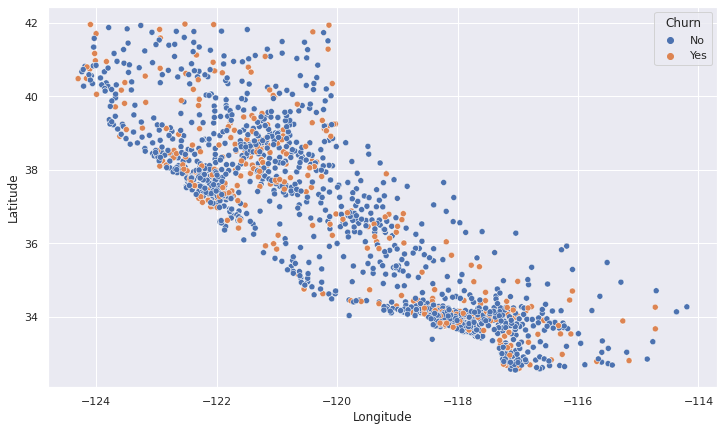

In [399]:
sns.scatterplot(data = df, x = 'Longitude', y = 'Latitude', hue = 'Churn')

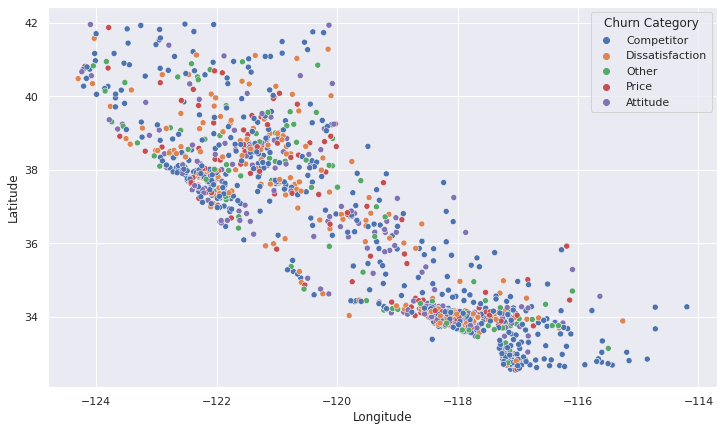

In [400]:
sns.scatterplot(data = df_churn, x = 'Longitude', y = 'Latitude', hue = 'Churn Category')

In [403]:
df_churn['City'].value_counts()

Los Angeles      90
San Diego        50
San Francisco    31
San Jose         29
Sacramento       26
                 ..
Zenia             1
Bieber            1
Sierra Madre      1
Sonoma            1
King City         1
Name: City, Length: 833, dtype: int64

In [404]:
df['City'].value_counts()

Los Angeles      305
San Diego        150
San Jose         112
Sacramento       108
San Francisco    104
                ... 
Hood               4
Byron              4
Vallecito          4
Farmersville       4
Meadow Valley      4
Name: City, Length: 1129, dtype: int64

## Percentage of Churn by Categorical Feature

Graphing by percentage churned may be visually easier to understand.

### Demographics

In [405]:
demographics = ['gender', 'Partner', 'Dependents', 'SeniorCitizen']

In [406]:
percentChurn = {}
for cat_col in demographics:
    percentChurn[cat_col] = df_churn[cat_col].value_counts().sort_index() / df[cat_col].value_counts().sort_index() * 100

Text(0.5, 0.98, 'Churn Percentage by Demographic')

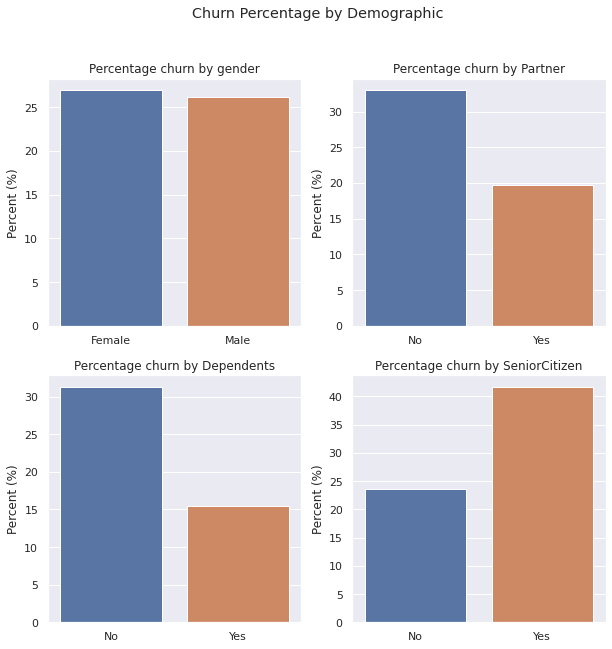

In [407]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i, col in zip(range(0, len(demographics)), demographics):
    sns.barplot(x = percentChurn[col].index, y = percentChurn[col].values, ax = axes[i])
    axes[i].set_title(f"Percentage churn by {col}")
    axes[i].set_ylabel("Percent (%)")
    axes[i]
fig.suptitle("Churn Percentage by Demographic")

Customers without partners, customers without dependents, and senior citizens are most likely to churn.

### Function to test significant differences in reasons based on population

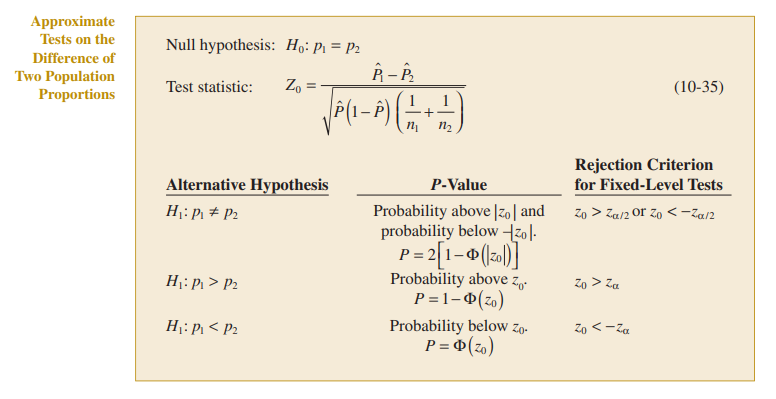

In [517]:
from scipy.stats import norm
def reason_by_group(df, target, group_column, group_category, reason_column, alpha = 0.1):
    # null hypothesis: the proportion of a group giving a certain reason is equal to the proportion of the whole giving that reason
    df_target = df[df[target] == 'Yes'] #churned
    df_nottarget = df[df[target] == 'No'] #not churned
    df_target_group = df_target[df_target[group_column] == group_category] # senior citizens who have churned
    df_others = df_target[df_target[group_column] != group_category] # non-senior citzens who have churned

    ## reasons given by senior citizens who have churned
    population1 = df_target_group[reason_column].value_counts().sort_index()
    n1 = df_target_group.shape[0]

    # reasons given by all others who have churned
    population2 = df_others[reason_column].value_counts().sort_index()
    n2 = df_others.shape[0]

    # p1 is the proportion of the certain group giving a certain reason
    # p2 is the proportion of the whole dataset giving that reason
    # alternative H1: p1 > p2
    p_values_greater = {}

     # alternative H1: p1 < p2
    p_values_less = {}

    for i, reason in enumerate(population1.index):
        #standard error of difference
        x1 = population1[reason]
        p1 = x1 / n1
        x2 = population2[reason]
        p2 = x2 / n2
        P = (x1 + x2) / (n1 + n2)

        z0 = (p1 - p2) / np.sqrt(P * (1- P) * (1/n1 + 1/n2))
        p_greater = 1- norm.cdf(z0)
        p_less = norm.cdf(z0)

        p_values_greater[reason] = p_greater
        p_values_less[reason] = p_less



    # return only reasons for which we can reject the null hypothesis
    return [{key:value for (key,value) in p_values_greater.items() if value < alpha},
         {key:value for (key,value) in p_values_less.items() if value < alpha}]

In [549]:
def graph_likely_reasons_by_group(group, morelikelyreasons, lesslikelyreasons):
    keys = list(morelikelyreasons.keys())
    vals = [(float(1 - morelikelyreasons[k]) * 100) for k in keys]
    plot = sns.barplot(x=keys, y=vals)
    plot.set_xlabel(f'Most Likely Churn Reasons by Group: "{group}"')
    plot.set_ylabel('Percentage compared to all customers')

In [529]:
# Customers without Partners
[morelikelyreasons, lesslikelyreasons] = reason_by_group(df, "Churn", "Partner", "No", "Churn Reason")
morelikelyreasons

{'Attitude of support person': 0.08276565122169055,
 'Competitor made better offer': 0.09617572985681166,
 'Price too high': 0.06272651984436639}

In [ ]:
plt.style.use('seaborn')
plt.bar(df_churn['ChurnReason'], bins = 'auto', edgecolor = 'navy', label = 'Dogs');
plt.bar(df['Percentage of Cat Owners'], bins = 'auto', edgecolor = 'orange', alpha = 0.75, color = 'lightsalmon', label = 'Cats')
plt.xlabel('Percentage of Animal Owners')
plt.ylabel('Count')
plt.legend();

In [522]:
# customers without dependents
[morelikelyreasons, lesslikelyreasons] = reason_by_group(df, "Churn", "Dependents", "No", "Churn Reason")
morelikelyreasons

{'Limited range of services': 0.030095471251735062,
 'Network reliability': 0.016675924139751164}

In [520]:
# senior citizen customers
[morelikelyreasons, lesslikelyreasons] = reason_by_group(df, "Churn", "SeniorCitizen", "Yes", "Churn Reason")
morelikelyreasons

{'Competitor made better offer': 0.0063923083741005415,
 'Extra data charges': 0.08314742278530052,
 'Limited range of services': 0.04660422185400359,
 'Price too high': 0.01564092300050479}

### Base Service (Phone or Internet)

In [408]:
base_services = ['PhoneService', 'InternetService']
percentChurn = {}
for cat_col in base_services:
    percentChurn[cat_col] = df_churn[cat_col].value_counts().sort_index() / df[cat_col].value_counts().sort_index() * 100

Text(0.5, 0.98, 'Churn Percentage by Base Service')

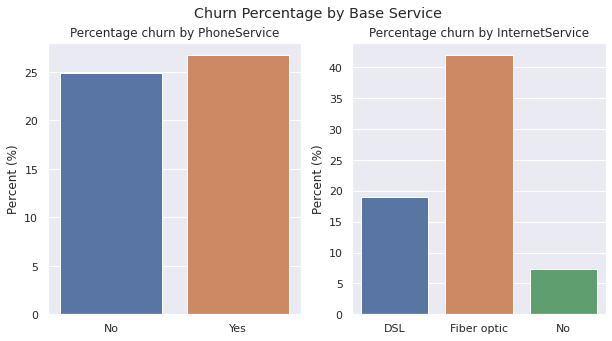

In [409]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

for i, col in zip(range(0, len(base_services)), base_services):
    sns.barplot(x = percentChurn[col].index, y = percentChurn[col].values, ax = axes[i])
    axes[i].set_title(f"Percentage churn by {col}")
    axes[i].set_ylabel("Percent (%)")
fig.suptitle("Churn Percentage by Base Service")

In [553]:
# Customers with Fiber Optic Internet
[morelikelyreasons, lesslikelyreasons] = reason_by_group(df, "Churn", "InternetService", "Fiber optic", "Churn Reason")
morelikelyreasons

{'Attitude of service provider': 0.07801696261533486,
 'Competitor made better offer': 0.09587539466121497,
 'Competitor offered more data': 0.08817126280259757}

### Additional Service Opt-In

In [410]:
phone_customers = df[df['PhoneService'] == 'Yes']
phone_customers_churn = phone_customers[phone_customers['Churn'] == 'Yes']

Text(0, 0.5, 'Percent (%)')

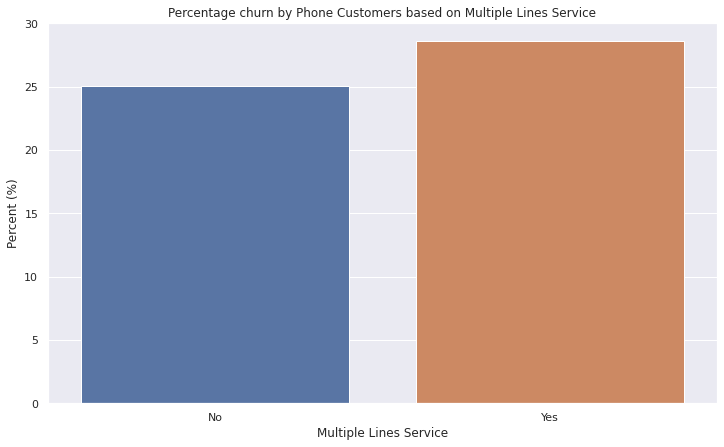

In [556]:
percentChurn['MultipleLines'] = phone_customers_churn['MultipleLines'].value_counts().sort_index()/phone_customers['MultipleLines'].value_counts().sort_index() * 100
plot = sns.barplot(x = percentChurn['MultipleLines'].index, y = percentChurn['MultipleLines'].values)
plot.set_title(f"Percentage churn by Phone Customers based on Multiple Lines Service")
plot.set_xlabel("Multiple Lines Service")
plot.set_ylabel("Percent (%)")

#### All Internet Customers

In [413]:
# internet services
add_int_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
       'StreamingTV', 'StreamingMovies']

In [558]:
internet_customers = df[df['InternetService'] != 'No']
internet_customers_churn = internet_customers[internet_customers['Churn'] == 'Yes']

In [562]:
percentChurn = {}
for cat_col in add_int_services:
    percentChurn[cat_col] = internet_customers_churn[cat_col].value_counts().sort_index() / internet_customers[cat_col].value_counts().sort_index() * 100

Text(0.5, 0.98, 'Churn Percentage by all Internet Customers')

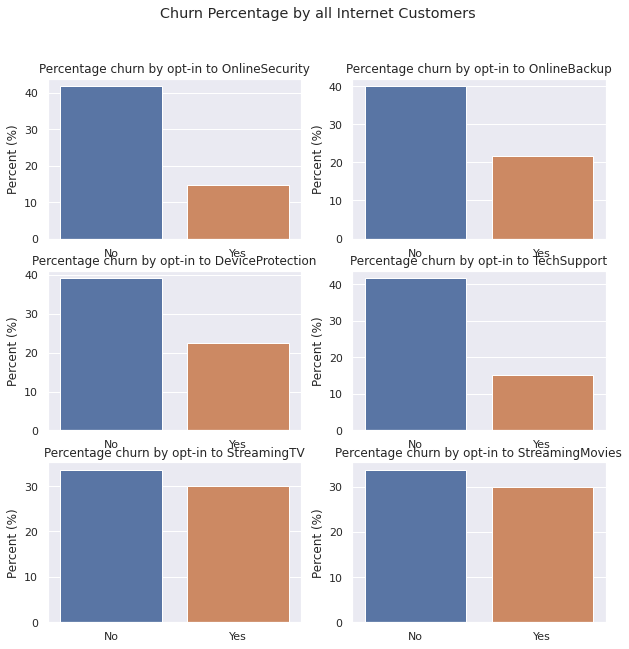

In [563]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()

for i, col in zip(range(0, len(add_int_services)), add_int_services):
    sns.barplot(x = percentChurn[col].index, y = percentChurn[col].values, ax = axes[i])
    axes[i].set_title(f"Percentage churn by opt-in to {col}")
    axes[i].set_ylabel("Percent (%)")
fig.suptitle("Churn Percentage by all Internet Customers")

#### Fiber optic customers

In [412]:
fo_internet_customers = df[df['InternetService'] == 'Fiber optic']
fo_internet_customers_churn = fo_internet_customers[fo_internet_customers['Churn'] == 'Yes']

In [416]:
percentChurn = {}
for cat_col in add_int_services:
    percentChurn[cat_col] = fo_internet_customers_churn[cat_col].value_counts().sort_index() / fo_internet_customers[cat_col].value_counts().sort_index() * 100

Text(0.5, 0.98, 'Churn Percentage by Fiber Optic Customers')

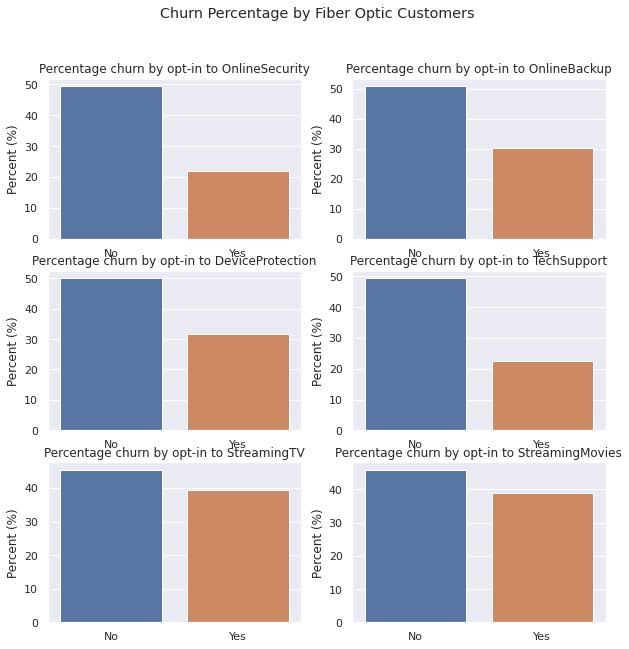

In [417]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()

for i, col in zip(range(0, len(add_int_services)), add_int_services):
    sns.barplot(x = percentChurn[col].index, y = percentChurn[col].values, ax = axes[i])
    axes[i].set_title(f"Percentage churn by opt-in to {col}")
    axes[i].set_ylabel("Percent (%)")
fig.suptitle("Churn Percentage by Fiber Optic Customers")

#### DSL customers

In [418]:
dsl_internet_customers = df[df['InternetService'] == 'DSL']
dsl_internet_customers_churn = dsl_internet_customers[dsl_internet_customers['Churn'] == 'Yes']

In [419]:
percentChurn = {}
for cat_col in add_int_services:
    percentChurn[cat_col] = dsl_internet_customers_churn[cat_col].value_counts().sort_index() / dsl_internet_customers[cat_col].value_counts().sort_index() * 100

Text(0.5, 0.98, 'Churn Percentage by DSL Customers')

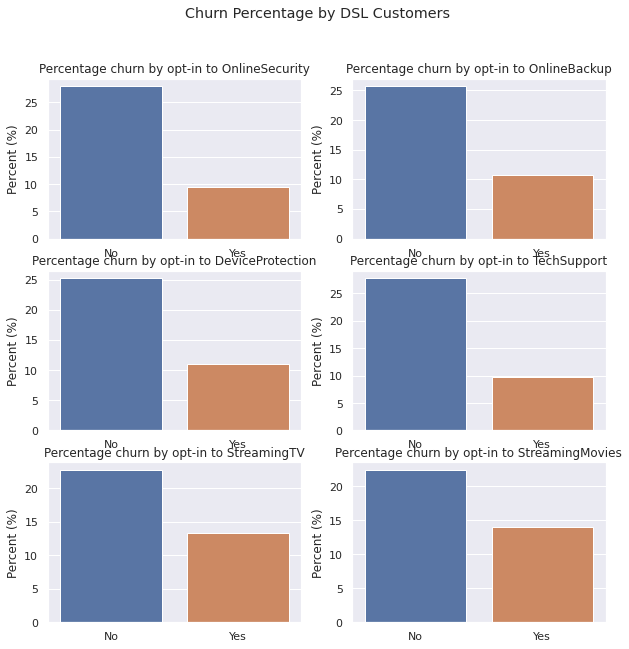

In [420]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()

for i, col in zip(range(0, len(add_int_services)), add_int_services):
    sns.barplot(x = percentChurn[col].index, y = percentChurn[col].values, ax = axes[i])
    axes[i].set_title(f"Percentage churn by opt-in to {col}")
    axes[i].set_ylabel("Percent (%)")
fig.suptitle("Churn Percentage by DSL Customers")

### Account Information

In [434]:
acc_info = ['Contract', 'PaperlessBilling', 'PaymentMethod']

In [435]:
percentChurn = {}
for cat_col in acc_info:
    percentChurn[cat_col] = df_churn[cat_col].value_counts().sort_index() / df[cat_col].value_counts().sort_index() * 100

In [438]:
percentChurn['PaymentMethod'].sort_values(ascending = False).index

Index(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'],
      dtype='object')

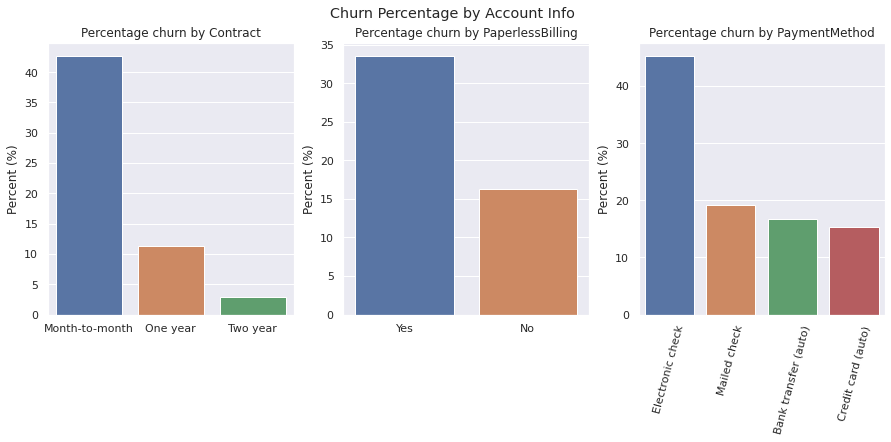

In [439]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i, col in zip(range(0, len(acc_info)), acc_info):
    sns.barplot(x = percentChurn[col].index, y = percentChurn[col].values, ax = axes[i], order = percentChurn[col].sort_values(ascending = False).index)
    axes[i].set_title(f"Percentage churn by {col}")
    axes[i].set_ylabel("Percent (%)")
fig.suptitle("Churn Percentage by Account Info")
axes[2].set_xticklabels(['Electronic check', 'Mailed check', 'Bank transfer (auto)', 'Credit card (auto)'], rotation = 75);

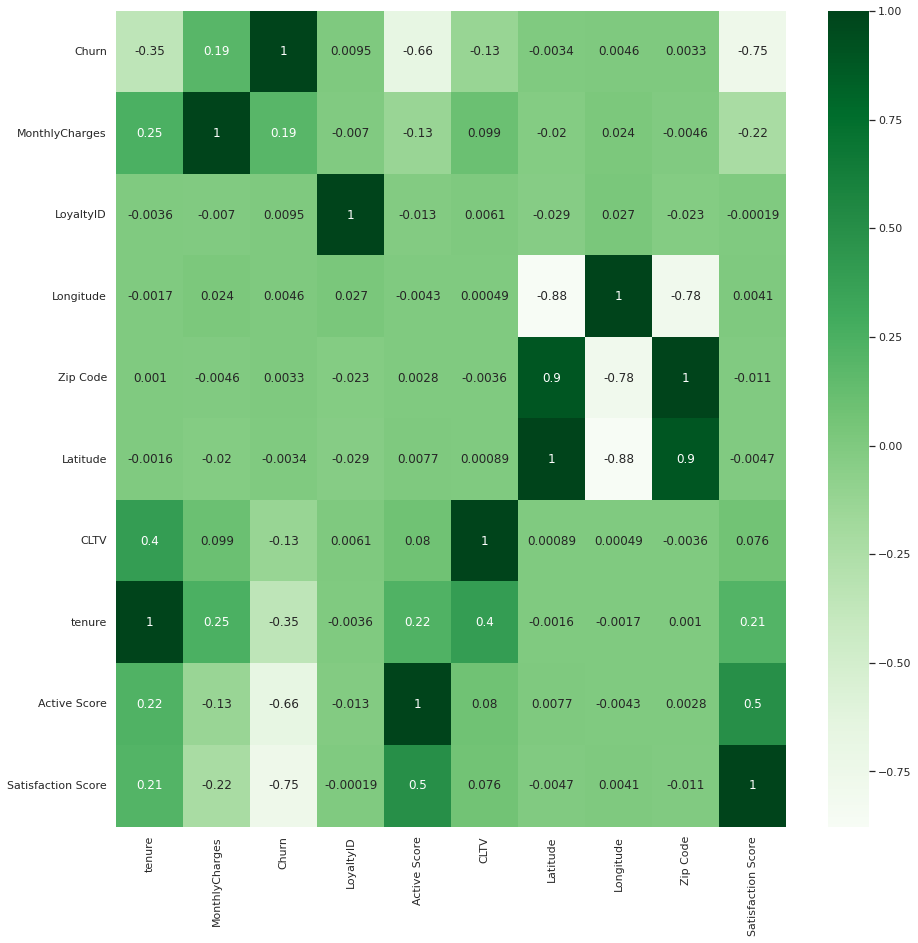

In [440]:
# correlations
corr = dftemp.corr().sort_values('Churn', ascending = False)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, cmap = 'Greens', annot = True);